## Import packages

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib
import re
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'Times New Roman'

# Bertopic
import tensorflow as tf
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from transformers.pipelines import pipeline
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sentence_transformers import SentenceTransformer

## Load data

In [2]:
df = pd.read_csv('/Users/deankuo/Desktop/R/dessertation/tokenize_japan.csv')
df = df.drop(columns=['Unnamed: 0'])

# Define a function to parse the file_name
def parse_file_name(row):
    file_name = row['file_name'][:-4]
    year, state_en, _, name = file_name.split('_')[:4]
    row['LNAME'] = f'{year}_{name}'
    row['STATE'] = state_en
    return row

# Apply the function to each row of the dataframe
df = df.apply(parse_file_name, axis=1)

print(df.shape)

df.head(5)

(7480, 5)


,file_name,content,tokens,LNAME,STATE
0,1986_Gumma_群馬県_谷津よしお.txt,郷土は人を育て、人は郷土につくす。「雑草の政治」をめざして！！\n私は「雑草の政治」を確固と...,郷土 は を 育て は 郷土 に つくす 雑草 の 政治 を ざ し て 私 は 雑草 の ...,1986_谷津よしお,Gumma
1,1986_Fukuoka_福岡県_つの嘉代.txt,子どもやおとしよりを大切にする政治を。子どもの「いじめ」や非行、老人医療の有料化でふえるおと...,子ども や お と し を 大切 に 政治 を 子ども の いじめ や 非行 老人 医療 の...,1986_つの嘉代,Fukuoka
2,1986_Yamaguchi_山口県_へや孝之.txt,汗と税、むだにしません。\n今こそ、減税が必要です。「税金は国民の暮らしのために使われ、負担...,汗 と 税 むだ に しま せん こそ 減税 が 必要 税金 は 国民 の 暮らし の ため...,1986_へや孝之,Yamaguchi
3,1986_Chiba_千葉県_宇野ひろし.txt,フレッシュ！行動派。\n米ソ連両超大国の対立による国際緊張、核戦争への不安、そして貿易摩擦や...,フレッシュ 行動 派 米 ソ連 両 大国 の 対立 による 国際 緊張 核 戦争 へ の 不...,1986_宇野ひろし,Chiba
4,1986_Nagasaki_長崎県_金子原ニ郎.txt,ごあいさつ。二回目の立候補にあたり、まず、この二年半、私を国政に参画させて頂いた皆様の暖かい...,ご 二回 の 立候補 にあたり この 二年 私 を 国政 に 参画 せ て 頂 い た の ...,1986_金子原ニ郎,Nagasaki


## Preprocessing for text data

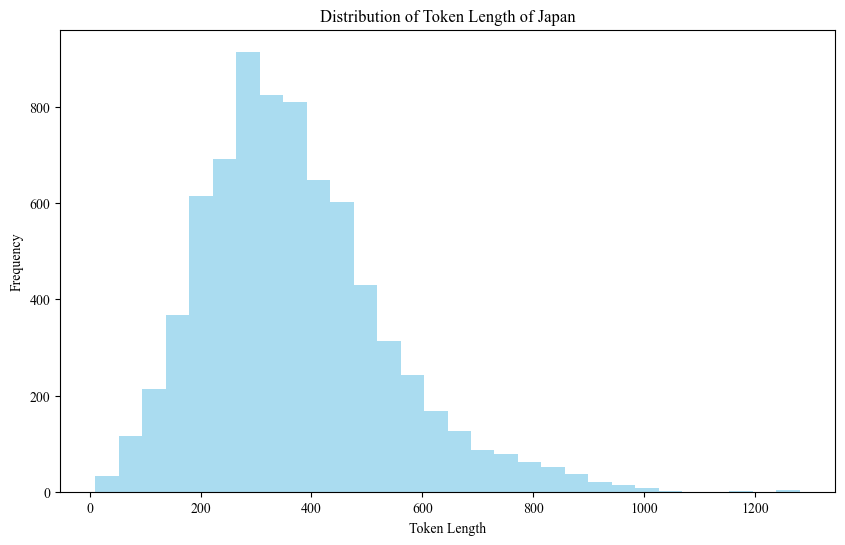

In [30]:
# 計算 TOKEN 欄位中的每個詞彙數（長度）
df['TOKEN_LENGTH'] = df['tokens'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(df['TOKEN_LENGTH'], bins=30, alpha=0.7, color='skyblue')
plt.title('Distribution of Token Length of Japan')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.savefig('Distribution of token length')


In [4]:
df_text = df[df['TOKEN_LENGTH'] >= 10]
df_text[df_text['TOKEN_LENGTH'] >= 512]

,file_name,content,tokens,LNAME,STATE,TOKEN_LENGTH
1,1986_Fukuoka_福岡県_つの嘉代.txt,子どもやおとしよりを大切にする政治を。子どもの「いじめ」や非行、老人医療の有料化でふえるおと...,子ども や お と し を 大切 に 政治 を 子ども の いじめ や 非行 老人 医療 の...,1986_つの嘉代,Fukuoka,614
5,1986_Tottori_鳥取県_武部文.txt,わたしの信念。人はまず誠実が基本です。いかに高位高官を極めても嘘いつわりのあるところに、蔑視...,わたし の 信念 は 誠実 が 基本 高位 高官 を も 嘘 いつ わり の ところ に 蔑...,1986_武部文,Tottori,781
7,1986_Aichi_愛知県_稲垣実男 .txt,ありがたいふるさと、西三河。西三河のみなさま、お元気でいらっしゃいますか。この三年半「国民の...,ありがたい ふるさと 西 三河 西 三河 の みなさま お 元気 で いらっしゃい か この...,1986_稲垣実男,Aichi,542
8,1986_Shimane_島根県_中林よし子.txt,くらし・婦人のねがいを国政へ。\nごあいさつ。みなさんのご支援にささえられ、県民の願いを少し...,くらし 婦人 の ね がい を 国政 へ ご の ご 支援 に ささえ れ 県民 の を で...,1986_中林よし子,Shimane,563
9,1986_Mie_三重県_北川まさやす.txt,ごあいさつ。日頃のご支援まことにありがとうございます。皆様の厚いご支援により、二年半、国会で...,ご 日頃 の ご 支援 ありがとう ご ざ い の 厚い ご 支援 により 二年 国会 で ...,1986_北川まさやす,Mie,608
...,...,...,...,...,...,...
7443,2009_Ibaraki_茨城県_おかべ英明.txt,景気回復・医療再生やりとげます\n日本は、アメリカ発世界同時不況のなか厳しい経済環境にありま...,景気 回復 医療 再生 や り と げ 日本 は アメリカ 発 世界 同時 不況 の なか ...,2009_おかべ英明,Ibaraki,642
7447,2009_Tochigi_栃木県_渡辺よしみ.txt,「脱官僚」「地域主権」「生活重視」で国民の手に政治を奪還する！\n私達は当たり前の自由社会・...,脱 官僚 地域 主権 生活 重視 で 国民 の 手 に 政治 を 奪還 私 は 当たり前 の...,2009_渡辺よしみ,Tochigi,746
7467,2009_Kanagawa_神奈川県_神山洋介.txt,「自律と共助の国ニッポン」へ\n三歳だった娘が、いつの間にか、一人でトイレを済ませていたとき...,自律 と 共助 の 国 ニッポン へ 三歳 だ っ た 娘 が いつの間にか 一人 で トイ...,2009_神山洋介,Kanagawa,560
7474,2009_Fukushima_福島県_渡部あつし.txt,元気な会津をつくる！！‡今こそ景気対策！！‡渡辺あつしの７つの基本政策\n（１）戦後レジーム...,元気 な 会津 を つくる こそ 景気 対策 渡辺 あ つ し の つ の 基本 政策 戦後...,2009_渡部あつし,Fukushima,773


In [72]:
def sliding_window(text, l_name, text_len, max_len=512, stride=256):
    """對文本進行滑動窗口分割並返回 DataFrame"""
    tokens = text
    token_windows = []
    l_name_windows = []
    # 增加一個判斷，當 tokens 的長度小於 max_len 時，直接作為一個窗口
    if text_len <= max_len:
        token_windows.append(tokens)  # 把分詞結果組合回去，並以空格隔開
        l_name_windows.append(f"{l_name}1")
    else:
        for i in range(0, text_len, stride):
            token_window = tokens[i:i+max_len]
            token_windows.append(''.join(token_window))  # 把分詞結果組合回去，並以空格隔開
            l_name_windows.append(f"{l_name}{int(i/stride)+1}")  # 段落編號加1，從1開始
    return pd.DataFrame({"tokens": token_windows, "LNAME": l_name_windows})

df_list = [sliding_window(row['tokens'], row['LNAME'], row['TOKEN_LENGTH']) for _, row in df_text.iterrows()]
df_new = pd.concat(df_list).reset_index(drop=True)


In [73]:
df_new.head(5)

,tokens,LNAME
0,郷土 は を 育て は 郷土 に つくす 雑草 の 政治 を ざ し て 私 は 雑草 の ...,1986_谷津よしお1
1,子ども や お と し を 大切 に 政治 を 子ども の いじめ や 非行 老人 医療 の...,1986_つの嘉代1
2,まもる 政治 の 実現 に 全力 を つくし あなた の ご 支持 を 私 つ の 嘉代 に...,1986_つの嘉代2
3,で 四十 学級 マンモス 校 の 解消 を 実現 し ゆき とど い た 教育 で いじめ ...,1986_つの嘉代3
4,汗 と 税 むだ に しま せん こそ 減税 が 必要 税金 は 国民 の 暮らし の ため...,1986_へや孝之1


In [35]:
documents = df_new["tokens"].tolist()

embedding_model = pipeline("fill-mask", model="cl-tohoku/bert-base-japanese-whole-word-masking")

hdbscan_model = HDBSCAN( metric='euclidean', cluster_selection_method='eom', prediction_data=True)

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', transform_seed=42, random_state=69)


# 初始化BERTopic模型
topic_model = BERTopic(language="Japanese", 
                       verbose=True,
                       calculate_probabilities=True,
                       umap_model=umap_model,
                       hdbscan_model=hdbscan_model,
                       nr_topics=69)

# 進行主題建模
topics, probabilities = topic_model.fit_transform(documents)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/319 [00:00<?, ?it/s]

2023-05-29 10:28:59,047 - BERTopic - Transformed documents to Embeddings
2023-05-29 10:29:08,980 - BERTopic - Reduced dimensionality
2023-05-29 10:29:50,189 - BERTopic - Clustered reduced embeddings
2023-05-29 10:30:00,656 - BERTopic - Reduced number of topics from 267 to 69


In [36]:
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name
0,-1,5290,-1_政治_した_社会_改革
1,0,948,0_共産_日本_政治_増税
2,1,359,1_自民党_共産_献金_腐敗
3,2,298,2_改革_政治_市民_社会
4,3,254,3_消費_増税_国民_憲法
...,...,...,...
64,63,6,63_海底_弾薬_ｓｓｋ_カジノ
65,64,6,64_受け取り_独立_自主_どんな
66,65,6,65_改革_小泉_再生_女性
67,66,6,66_環境_地球_自然_好き


In [ ]:
topic_model.visualize_topics()

In [74]:
topic_column = topic_model.get_document_info(df_new['tokens'])
topic_column

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,郷土 は を 育て は 郷土 に つくす 雑草 の 政治 を ざ し て 私 は 雑草 の ...,0,0_共産_日本_政治_増税,共産 - 日本 - 政治 - 増税 - 国民 - した - 消費 - ため - から - って,1.000000,False
1,子ども や お と し を 大切 に 政治 を 子ども の いじめ や 非行 老人 医療 の...,-1,-1_政治_した_社会_改革,政治 - した - 社会 - 改革 - ため - 日本 - 実現 - こと - 国民 - から,0.900932,False
2,まもる 政治 の 実現 に 全力 を つくし あなた の ご 支持 を 私 つ の 嘉代 に...,-1,-1_政治_した_社会_改革,政治 - した - 社会 - 改革 - ため - 日本 - 実現 - こと - 国民 - から,0.823314,False
3,で 四十 学級 マンモス 校 の 解消 を 実現 し ゆき とど い た 教育 で いじめ ...,-1,-1_政治_した_社会_改革,政治 - した - 社会 - 改革 - ため - 日本 - 実現 - こと - 国民 - から,0.061488,False
4,汗 と 税 むだ に しま せん こそ 減税 が 必要 税金 は 国民 の 暮らし の ため...,8,8_消費_廃止_国民_増税,消費 - 廃止 - 国民 - 増税 - 政治 - 税制 - 反対 - 税率 - 実現 - 減税,0.142122,False
...,...,...,...,...,...,...
10195,反省 し そして 責任 政治 を 実行 国民 と 政治家 と の 信頼 関係 こそ 国 づく...,-1,-1_政治_した_社会_改革,政治 - した - 社会 - 改革 - ため - 日本 - 実現 - こと - 国民 - から,0.083317,False
10196,り に 責任 決断 責任 政治 を 実行 し ふるさと 発 の 国 づくり 私 は この 地...,25,25_地方_地域_として_分権,地方 - 地域 - として - 分権 - 整備 - づくり - 市民 - 首都 - 国政 - 都市,0.131188,False
10197,ため 日本 の ため まじめ に 一生懸命 がん ばり よい よい 町 よい 国 づくり ...,2,2_改革_政治_市民_社会,改革 - 政治 - 市民 - 社会 - ため - した - から - 日本 - こと - 経済,1.000000,False
10198,日本 の 伝統 を 大切 に 保守 政治 で 安心 温 い 共生 社会 を 創 り ま しょ...,-1,-1_政治_した_社会_改革,政治 - した - 社会 - 改革 - ため - 日本 - 実現 - こと - 国民 - から,0.016528,False


In [ ]:
topic_distr, _ = topic_model.approximate_distribution(documents)
topic_model.visualize_distribution(topic_distr[1])

In [40]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(documents, calculate_tokens=True)

# Visualize the token-level distributions
df_distribution = topic_model.visualize_approximate_distribution(documents[1], topic_token_distr[1])
df_distribution

100%|██████████| 11/11 [00:30<00:00,  2.81s/it]


,子ども,大切,政治,子ども,いじめ,非行,老人,医療,有料,ふえる,自殺,本当に,痛み,女優,吉永,小百合,戦闘機,買う,教育,とか,福祉,税金,かって,ほしい,訴え,した,中曽根,内閣,年間,軍事,ふえ,千億,軍艦,一隻,だけ,四十,学級,九百,老人,医療,無料,復活,実現,自民党,悪政,転換,子ども,平和,まもる,政治,実現,全力,つくし,あなた,支持,嘉代,寄せ,さい,心から,おねがい,五千,所得,減税,是正,四十,学級,実現,自民党,本音,増税,マル優,廃止,大型,間接,絶対に,しま,せん,企業,優遇,不公平,税制,改め,軍事,一兆,六千,大幅,減税,実現,異常,是正,差益,還元,すすめ,大幅,賃上げ,国民,活力,経済
0_共産_日本_政治_増税,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.104,0.211,0.211,0.211,0.107,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1_自民党_共産_献金_腐敗,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.141,0.298,0.435,0.538,0.397,0.240,0.103,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.115,0.226,0.226,0.226,0.111,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3_消費_増税_国民_憲法,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.103,0.210,0.210,0.318,0.214,0.108,0.108,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7_消費_廃止_自民党_国民,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.107,0.231,0.337,0.337,0.230,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.100,0.100,0.100,0.218,0.118,0.118,0.118,0.000,0.000,0.108,0.108,0.210,0.210,0.102,0.102,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8_消費_廃止_国民_増税,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.103,0.103,0.103,0.103,0.000,0.000,0.000,0.000,0.116,0.116,0.228,0.228,0.112,0.112,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
14_自公_高校_後期_政権,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.124,0.280,0.401,0.401,0.277,0.121,0.000,0.000,0.000,0.000,0.000,0.103,0.103,0.103,0.103,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
15_医療_地域_社会_雇用,0.113,0.113,0.113,0.113,0.000,0.000,0.000,0.000,0.0

In [41]:
topic_model.visualize_term_rank() 

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertext': '<b>Topic -1</b>:政治_した_社会_改革_ため_日本_実現_こと_国民_から',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.01095783, 0.00979787, 0.00954752, 0.00917191, 0.00902936, 0.00870957,
                          0.00819165, 0.00812665, 0.00775479, 0.00765349])},
             {'hovertext': '<b>Topic 0</b>:共産_日本_政治_増税_国民_した_消費_ため_から_って',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.01368657, 0.0126546 , 0.01197873, 0.01105243, 0.01105125, 0.01039815,
                          0.01006313, 0.00868441, 0.00862836, 0.00795446])},
             {'hovertext': '<b>Topic 1</b>:自民党_共産_献金_腐敗_政治_企業_改革_国民_選挙_日本',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.02187061, 0.02014161, 0.01961532, 0.01930348, 0.01895936, 0.01839625,
                          0.01621046, 0.01570098, 0.01552294, 0.01413299])},
             {'hovertext': '<b>Topic 2</b>:改革_政治_市民_社会_ため_した_から_日本_こと_経済',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.01189539, 0.01125682, 0.01114505, 0.0108625 , 0.01025591, 0.00979892,
                          0.00979791, 0.00861351, 0.00847996, 0.00842603])},
             {'hovertext': '<b>Topic 3</b>:消費_増税_国民_憲法_保障_年金_税金_日本_民主_くらし',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.01361933, 0.01307686, 0.01047382, 0.01035813, 0.01035525, 0.01034343,
                          0.01018418, 0.01011622, 0.01003332, 0.00992647])},
             {'hovertext': '<b>Topic 4</b>:増税_憲法_改悪_消費_共産_民主_日本_戦争_くらし_たしか',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.02983349, 0.02604577, 0.02205128, 0.0161555 , 0.0161421 , 0.01558206,
                          0.01528895, 0.01521091, 0.01486314, 0.01481044])},
             {'hovertext': '<b>Topic 5</b>:政治_こと_した_政治家_社会_ため_国民_てい_から_生活',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.01596872, 0.01008169, 0.00997861, 0.00991487, 0.00951853, 0.00930526,
                          0.00827137, 0.00823256, 0.00821153, 0.00811868])},
             {'hovertext': '<b>Topic 6</b>:年金_制度_保険_保障_廃止_削減_地域_財源_改革_道路',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.03145176, 0.01683747, 0.01418483, 0.01147117, 0.01144409, 0.01137323,
                          0.01041375, 0.01037505, 0.00999232, 

In [42]:
topic_dict = {}
for i in range(topic_info.shape[0]-1):
    # 注意get_topic返回的是一個tuple列表，我們只需要每個tuple的第一個元素，即關鍵字本身
    keywords = topic_model.get_topic(i)
    words = []
    for word in keywords:
        words.append(word[0])
    topic_dict['Topic' + str(i)] = words
    
# 將字典轉換成DataFrame
topic_df = pd.DataFrame(topic_dict)

topic_df

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic58,Topic59,Topic60,Topic61,Topic62,Topic63,Topic64,Topic65,Topic66,Topic67
0,共産,自民党,改革,消費,増税,政治,年金,消費,消費,選挙,...,環境,労働,戦争,増税,岩手,海底,受け取り,改革,環境,オーケー
1,日本,共産,政治,増税,憲法,こと,制度,廃止,廃止,した,...,医療,再建,イラク,民営,奄美,弾薬,独立,小泉,地球,ok
2,政治,献金,市民,国民,改悪,した,保険,自民党,国民,政治,...,リサイクル,雇用,無駄遣い,郵政,づくり,ｓｓｋ,自主,再生,自然,政治家
3,増税,腐敗,社会,憲法,消費,政治家,保障,国民,増税,上げ,...,地球,八万,原爆,たしか,大島つむぎ,カジノ,どんな,女性,好き,込み
4,国民,政治,ため,保障,共産,社会,廃止,共産,政治,支援,...,介護,改正,負担,サラリーマン,不況,護岸,立場,接種,積極,あたりまえ
5,した,企業,した,年金,民主,ため,削減,政治,税制,ため,...,太陽光,最低,民主,ふみの,ぐち,使用,めいてい,たい,美しい,官僚
6,消費,改革,から,税金,日本,国民,地域,コメ,反対,こと,...,責任,守り,存在,憲法,世帯,こころ,団体,四本柱,ヒロシマ,しん
7,ため,国民,日本,日本,戦争,てい,財源,反対,税率,立候補,...,開発,所得,平和,野党,愛知,農村,大国,大阪,解決,そんな
8,から,選挙,こと,民主,くらし,から,改革,選挙,実現,この,...,経済,抜本,投下,国民,減税,予算,製薬,制度,課題,特権
9,って,日本,経済,くらし,たしか,生活,道路,日本,減税,心から,...,胆振,派遣,広島,サービス,住宅,文盲,遠慮,未来,進藤,善意


In [43]:
# 占比最高的主題
keywords = topic_model.get_topic(7)
keywords

[('消費', 0.03151095593556421),
 ('廃止', 0.024345470777690385),
 ('自民党', 0.02150595713980665),
 ('国民', 0.018448688907460476),
 ('共産', 0.016948845741117016),
 ('政治', 0.015857871108461756),
 ('コメ', 0.01494977532263428),
 ('反対', 0.014750784362350632),
 ('選挙', 0.013587902262253475),
 ('日本', 0.013381296758209763)]

In [75]:
df_new[['TOPIC', 'PROBABILITY', 'REPRESENTATIVE']] = topic_column[['Topic', 'Probability', 'Representative_document']]
representative = df_new[df_new['REPRESENTATIVE'] == True]
representative.to_excel('representative_documents.xlsx')

In [76]:
pork = set([11, 17, 20, 23, 25, 32, 39, 41, 45, 46, 49, 50, 57, 62, 63]) 
df_new['PORK'] = df_new['TOPIC'].apply(lambda x: 1 if x in pork else 0)

In [88]:
df_new['CANDIDATE'] = df_new['LNAME'].apply(lambda x: str(x)[:-1])

candidate_doc_counts = df_new['CANDIDATE'].value_counts()
candidate_pork_counts = df_new[df_new['PORK'] == 1]['CANDIDATE'].value_counts()
df_candidate_counts = pd.DataFrame({'DOCS_TOTAL': candidate_doc_counts, 'PORK_DOCS': candidate_pork_counts}).fillna(0)
df_candidate_counts['PORK_RATIO'] = df_candidate_counts['PORK_DOCS'] / df_candidate_counts['DOCS_TOTAL']
df_candidate_counts = df_candidate_counts.reset_index()
df_candidate_counts.rename(columns={'index': 'CANDIDATE'}, inplace=True)
df_candidate_counts['YEAR'] = df_candidate_counts['LNAME'].apply(lambda x: str(x)[:4])

In [89]:
df_candidate_counts.head(5)

,CANDIDATE,DOCS_TOTAL,PORK_DOCS,PORK_RATIO
0,1986_あいさわ一,1,1.0,1.0
1,1986_あいの興一,1,0.0,0.0
2,1986_あかぎ宗,1,0.0,0.0
3,1986_あさの勝,1,0.0,0.0
4,1986_あべ令,1,0.0,0.0


In [93]:
df_1 = pd.merge(df_new, df_candidate_counts, on='CANDIDATE', how='inner')
df_1.head(5)

,tokens,LNAME,TOPIC,PROBABILITY,REPRESENTATIVE,PORK,CANDIDATE,YEAR,DOCS_TOTAL,PORK_DOCS,PORK_RATIO
0,郷土 は を 育て は 郷土 に つくす 雑草 の 政治 を ざ し て 私 は 雑草 の ...,1986_谷津よしお,0,1.000000,False,0,1986_谷津よし,1986,1,0.0,0.0
1,子ども や お と し を 大切 に 政治 を 子ども の いじめ や 非行 老人 医療 の...,1986_つの嘉代,-1,0.900932,False,0,1986_つの嘉,1986,1,0.0,0.0
2,汗 と 税 むだ に しま せん こそ 減税 が 必要 税金 は 国民 の 暮らし の ため...,1986_へや孝之,8,0.142122,False,0,1986_へや孝,1986,1,0.0,0.0
3,フレッシュ 行動 派 米 ソ連 両 大国 の 対立 による 国際 緊張 核 戦争 へ の 不...,1986_宇野ひろし,40,0.162313,True,0,1986_宇野ひろ,1986,1,0.0,0.0
4,ご 二回 の 立候補 にあたり この 二年 私 を 国政 に 参画 せ て 頂 い た の ...,1986_金子原ニ郎,9,0.211143,False,0,1986_金子原ニ,1986,1,0.0,0.0


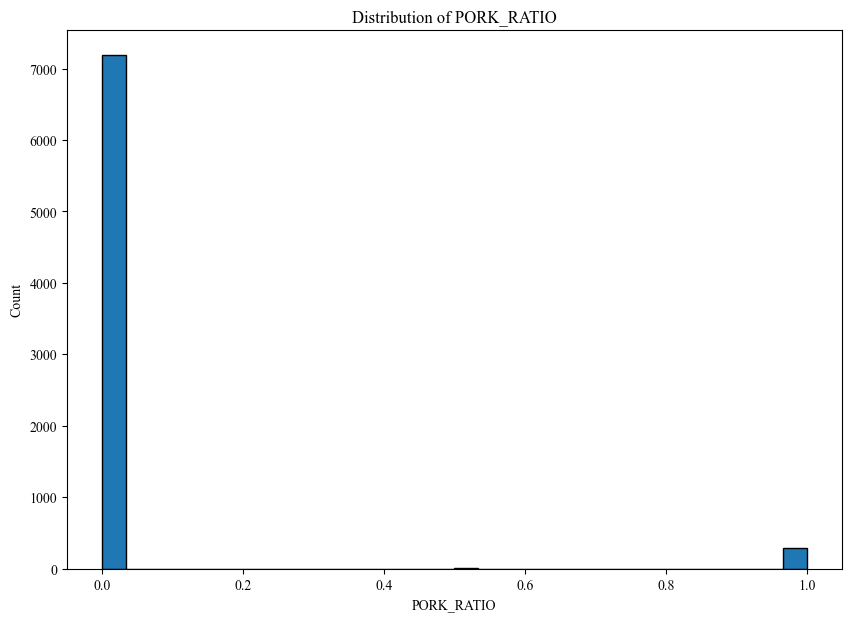

In [94]:
plt.figure(figsize=(10, 7))
plt.hist(df_1['PORK_RATIO'], bins=30, edgecolor='black')
plt.title('Distribution of PORK_RATIO')
plt.xlabel('PORK_RATIO')
plt.ylabel('Count')
plt.show()

In [96]:
df_1 = df_1.drop(['CANDIDATE'], axis=1)
duplicated_rows = df_1[df_1.duplicated()]
duplicated_rows

,tokens,LNAME,TOPIC,PROBABILITY,REPRESENTATIVE,PORK,YEAR,DOCS_TOTAL,PORK_DOCS,PORK_RATIO


In [100]:
df_ = df_1.drop_duplicates(subset=['LNAME'])
df_['FINAL_PORK'] = df_['PORK_RATIO'].apply(lambda x: 1 if x >= 0.2 else 0)
df_.shape

(7473, 11)

In [101]:
df_.to_excel('/Users/deankuo/Desktop/python/dissertation_replicate/bertopic_result.xlsx')

In [111]:
grouped = df_.groupby('YEAR')
ratios = grouped['FINAL_PORK'].value_counts(normalize=True).unstack()
ratios.rename(columns={0: "POLICY", 1: "PORK"}, inplace=True)
ratios.index = pd.to_numeric(ratios.index)

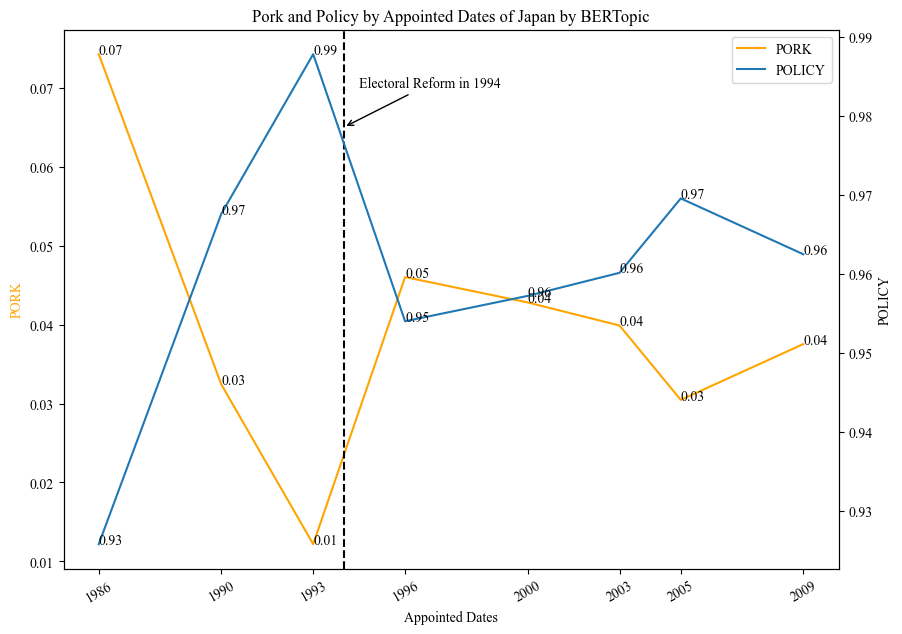

In [116]:
fig, ax1 = plt.subplots(figsize=(10,7))

# 繪製第一個數據集並設定標籤
ratios['PORK'].plot(kind='line', ax=ax1, color='orange', label='PORK')
ax1.set_ylabel('PORK', color='orange')

# 遍歷每一個點
for i, j in zip(ratios.index, ratios['PORK']):
    ax1.annotate(f'{j:.2f}', (i, j))  # 在每一個點上加上數值標記

ax2 = ax1.twinx()

# 繪製第二個數據集並設定標籤
ratios['POLICY'].plot(kind='line', ax=ax2, label='POLICY')
ax2.set_ylabel('POLICY')

# 遍歷每一個點
for i, j in zip(ratios.index, ratios['POLICY']):
    ax2.annotate(f'{j:.2f}', (i, j))  # 在每一個點上加上數值標記

# 設定標題和x軸標籤
ax1.set_title('Pork and Policy by Appointed Dates of Japan by BERTopic')
ax1.set_xlabel('Appointed Dates')

ax1.axvline(x=1994, color='black', linestyle='--')
ax1.annotate('Electoral Reform in 1994', xy=(1994, 0.065), xytext=(1994.5, 0.07),
            arrowprops=dict(facecolor='black', arrowstyle='->'))

# 產生新的x軸標籤
new_xticks = [f"{th}" for th in ratios.index]
ax1.set_xticks(ratios.index)
ax1.set_xticklabels(new_xticks, rotation=30)

# 添加兩個圖例到一個圖上
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.savefig('/Users/deankuo/Desktop/python/dissertation_replicate/Pork-Policy_Japan_BERTopic.png')
